In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tsfresh

from sklearn import linear_model, model_selection, metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFECV


%matplotlib inline

In [76]:
# read dataframe from covid_explore.ipynb output
covid = pd.read_csv("./data/covid/covid19_20210104_mod.csv", index_col='date', parse_dates=True)
# select columns of interest and remove all dates up to July 1
covid_mod = covid.loc['2020-07-01':,('days_elapse', 'new_count_update')].copy()
#covid_mod.reset_index(inplace=True, drop=True)
covid_mod.columns = ['days_elapse', 'daily_case']
# add a 3, 5, 7 and 14-day rolling mean
# also add a 14-day rolling std-dev in the event a 14-day standardization is used
covid_mod['daily_case_3mean'] = covid_mod['daily_case'].rolling(window = 3).mean()
covid_mod['daily_case_5mean'] = covid_mod['daily_case'].rolling(window = 5).mean()
covid_mod['daily_case_7mean'] = covid_mod['daily_case'].rolling(window = 7).mean()
covid_mod['daily_case_14mean'] = covid_mod['daily_case'].rolling(window = 14).mean()

In [82]:
covid_7day = pd.Series(covid_mod['daily_case_7mean'], index = covid_mod.index).dropna()

In [84]:
rolled1 = tsfresh.utilities.dataframe_functions.make_forecasting_frame(covid_7day, kind=1, max_timeshift=14, rolling_direction=1)
rolled2 = tsfresh.utilities.dataframe_functions.make_forecasting_frame(covid_7day, kind=1, max_timeshift=7, rolling_direction=1)

Rolling: 100%|██████████| 30/30 [00:02<00:00, 13.33it/s]


In [88]:
rolled1_mod = rolled1[0].groupby('id').filter(lambda x: len(x) >= 14)
rolled2_mod = rolled2[0].groupby('id').filter(lambda x: len(x) >= 7)

In [89]:
extracted_features1 = tsfresh.extract_features(rolled1_mod, column_id = 'id', column_sort = 'time', column_value = 'value')
extracted_features2 = tsfresh.extract_features(rolled2_mod, column_id = 'id', column_sort = 'time', column_value = 'value')

Feature Extraction: 100%|██████████| 29/29 [00:03<00:00,  8.18it/s]


In [90]:
extracted_features1 = extracted_features1.droplevel(0).add_suffix('_14')
extracted_features2 = extracted_features2.droplevel(0).add_suffix('_7')

In [91]:
extracted_features_combo = pd.concat([extracted_features1, extracted_features2], axis = 1, join='inner')

In [93]:
extracted_features_combo.head()

,value__variance_larger_than_standard_deviation_14,value__has_duplicate_max_14,value__has_duplicate_min_14,value__has_duplicate_14,value__sum_values_14,value__abs_energy_14,value__mean_abs_change_14,value__mean_change_14,value__mean_second_derivative_central_14,value__median_14,...,value__fourier_entropy__bins_2_7,value__fourier_entropy__bins_3_7,value__fourier_entropy__bins_5_7,value__fourier_entropy__bins_10_7,value__fourier_entropy__bins_100_7,value__permutation_entropy__dimension_3__tau_1_7,value__permutation_entropy__dimension_4__tau_1_7,value__permutation_entropy__dimension_5__tau_1_7,value__permutation_entropy__dimension_6__tau_1_7,value__permutation_entropy__dimension_7__tau_1_7
2020-07-21,1.0,0.0,0.0,0.0,258.571429,5071.551020,1.219780,1.219780,0.035714,19.642857,...,0.562335,0.562335,0.562335,1.039721,1.039721,-0.000000,-0.000000,-0.000000,-0.000000,-0.0
2020-07-22,1.0,0.0,0.0,0.0,276.571429,5776.122449,1.318681,1.318681,0.041667,19.928571,...,0.562335,0.562335,0.562335,0.562335,1.386294,-0.000000,-0.000000,-0.000000,-0.000000,-0.0
2020-07-23,1.0,0.0,0.0,0.0,295.571429,6571.408163,1.373626,1.373626,-0.029762,20.214286,...,0.562335,0.562335,0.562335,1.039721,1.386294,-0.000000,-0.000000,-0.000000,-0.000000,-0.0
2020-07-24,1.0,0.0,0.0,0.0,314.714286,7419.163265,1.274725,1.274725,-0.005952,20.500000,...,0.562335,0.562335,0.562335,1.039721,1.386294,-0.000000,-0.000000,-0.000000,-0.000000,-0.0
2020-07-25,1.0,0.0,0.0,0.0,331.142857,8186.612245,1.175824,1.153846,-0.065476,21.714286,...,0.562335,0.562335,1.039721,1.039721,1.386294,0.500402,0.562335,0.636514,0.693147,-0.0


In [94]:
from tsfresh.utilities.dataframe_functions import impute

In [95]:
impute(extracted_features_combo)

,value__variance_larger_than_standard_deviation_14,value__has_duplicate_max_14,value__has_duplicate_min_14,value__has_duplicate_14,value__sum_values_14,value__abs_energy_14,value__mean_abs_change_14,value__mean_change_14,value__mean_second_derivative_central_14,value__median_14,...,value__fourier_entropy__bins_2_7,value__fourier_entropy__bins_3_7,value__fourier_entropy__bins_5_7,value__fourier_entropy__bins_10_7,value__fourier_entropy__bins_100_7,value__permutation_entropy__dimension_3__tau_1_7,value__permutation_entropy__dimension_4__tau_1_7,value__permutation_entropy__dimension_5__tau_1_7,value__permutation_entropy__dimension_6__tau_1_7,value__permutation_entropy__dimension_7__tau_1_7
2020-07-21,1.0,0.0,0.0,0.0,258.571429,5.071551e+03,1.219780,1.219780,0.035714,19.642857,...,0.562335,0.562335,0.562335,1.039721,1.039721,-0.000000,-0.000000,-0.000000,-0.000000,-0.0
2020-07-22,1.0,0.0,0.0,0.0,276.571429,5.776122e+03,1.318681,1.318681,0.041667,19.928571,...,0.562335,0.562335,0.562335,0.562335,1.386294,-0.000000,-0.000000,-0.000000,-0.000000,-0.0
2020-07-23,1.0,0.0,0.0,0.0,295.571429,6.571408e+03,1.373626,1.373626,-0.029762,20.214286,...,0.562335,0.562335,0.562335,1.039721,1.386294,-0.000000,-0.000000,-0.000000,-0.000000,-0.0
2020-07-24,1.0,0.0,0.0,0.0,314.714286,7.419163e+03,1.274725,1.274725,-0.005952,20.500000,...,0.562335,0.562335,0.562335,1.039721,1.386294,-0.000000,-0.000000,-0.000000,-0.000000,-0.0
2020-07-25,1.0,0.0,0.0,0.0,331.142857,8.186612e+03,1.175824,1.153846,-0.065476,21.714286,...,0.562335,0.562335,1.039721,1.039721,1.386294,0.500402,0.562335,0.636514,0.693147,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1.0,0.0,0.0,0.0,8625.142857,5.365544e+06,15.703297,-12.780220,-1.886905,636.500000,...,0.562335,0.562335,0.562335,1.039721,1.039721,-0.000000,-0.000000,-0.000000,-0.000000,-0.0
2020-12-28,1.0,0.0,0.0,0.0,8450.142857,5.162219e+06,15.153846,-14.692308,-0.095238,605.571429,...,0.562335,0.562335,0.562335,0.562335,1.386294,-0.000000,-0.000000,-0.000000,-0.000000,-0.0
2020-12-29,1.0,0.0,0.0,0.0,8246.571429,4.925001e+06,15.615385,-15.153846,-0.648810,583.642857,...,0.562335,0.562335,0.562335,1.039721,1.386294,-0.000000,-0.000000,-0.000000,-0.000000,-0.0
2020-12-30,1.0,0.0,0.0,0.0,8040.857143,4.688429e+06,16.054945,-16.054945,-0.065476,569.357143,...,0.562335,0.562335,1.039721,1.039721,1.386294,-0.000000,-0.000000,-0.000000,-0.000000,-0.0


In [97]:
covid_7day_trunc = covid_7day['2020-07-21':]

In [98]:
from tsfresh import select_features
features_filtered = select_features(extracted_features_combo, covid_7day_trunc)

In [99]:
features_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 164 entries, 2020-07-21 to 2020-12-31
Freq: D
Columns: 315 entries, value__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)_7 to value__index_mass_quantile__q_0.8_14
dtypes: float64(315)
memory usage: 404.9 KB


In [100]:
X_train = features_filtered[:116]
y_train = covid_7day_trunc[:116]
X_test = features_filtered[116:]
y_test = covid_7day_trunc[116:]

In [104]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [105]:
train_result = model_rf.predict(X_train)
test_result = model_rf.predict(X_test)

In [106]:
total_result = np.concatenate((train_result, test_result))

In [107]:
result_df = pd.DataFrame(total_result, index = features_filtered.index, columns=['modelled'])

In [108]:
result_df = pd.concat([result_df, covid_7day_trunc], axis=1)

In [110]:
result_df

,modelled,daily_case_7mean
2020-07-21,29.350000,28.571429
2020-07-22,30.764286,30.428571
2020-07-23,31.512857,31.714286
2020-07-24,31.487143,31.571429
2020-07-25,30.652857,30.571429
...,...,...
2020-12-27,293.994286,493.428571
2020-12-28,288.825714,480.857143
2020-12-29,293.865714,472.142857
2020-12-30,299.620000,467.571429


<AxesSubplot:>

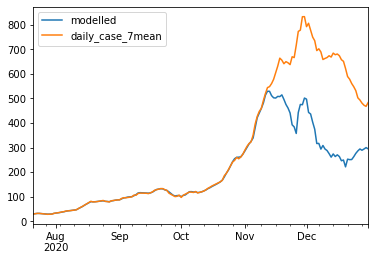

In [111]:
result_df.plot()

In [112]:
def performance(name, observed, modelled):
    output_RMSE = (metrics.mean_squared_error(observed, modelled))**(0.5)
    output_MAE = metrics.mean_absolute_error(observed, modelled)
    output_r2 = metrics.r2_score(observed, modelled)
    
    combine = [output_RMSE, output_MAE, output_r2]
        
    df = pd.DataFrame({name:combine}, index=['RMSE', 'MAE', 'R2'])

    return df

In [113]:
def modelling(train_x, train_y, test_x, test_y, model_type, name):
    if model_type == "lm":
        model = linear_model.LinearRegression()
    elif model_type == "rf":
        model = RandomForestRegressor()
    elif model_type == "gb":
        model = GradientBoostingRegressor()
        
    model.fit(train_x, train_y)
    train_score = performance((name + " train"), train_y, model.predict(train_x))
    test_score = performance((name + " test"), test_y, model.predict(test_x))

    return train_score, test_score, model

In [114]:
rf_tr_score, rf_te_score, rf_test = modelling(X_train, y_train, X_test, y_test, "rf", 'test')
rf_3_fit = pd.concat([rf_tr_score, rf_te_score], axis= 1)
rf_3_fit

,test train,test test
RMSE,3.711870,307.796955
MAE,1.978670,288.853869
R2,0.998978,-9.857454
